# Batch Classify Images

This script predicts labels from new images and stores results. 

In [86]:
# cd /media/ssd/crop_image_classifier/Scripts
#source activate tensorflow
#jupyter notebook

# run from python
import label_image
import sys
import numpy as np
import tensorflow as tf
import os
from datetime import datetime
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageDraw, ImageFont
import time
import psutil
import pandas as pd
import os, glob


def load_graph(model_file):
  graph = tf.Graph()
  graph_def = tf.GraphDef()

  with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
  with graph.as_default():
    tf.import_graph_def(graph_def)

  return graph


def read_tensor_from_image_file(file_name,
                                input_height=299,
                                input_width=299,
                                input_mean=0,
                                input_std=255):
  input_name = "file_reader"
  output_name = "normalized"
  file_reader = tf.read_file(file_name, input_name)
  if file_name.endswith(".png"):
    image_reader = tf.image.decode_png(
        file_reader, channels=3, name="png_reader")
  elif file_name.endswith(".gif"):
    image_reader = tf.squeeze(
        tf.image.decode_gif(file_reader, name="gif_reader"))
  elif file_name.endswith(".bmp"):
    image_reader = tf.image.decode_bmp(file_reader, name="bmp_reader")
  else:
    image_reader = tf.image.decode_jpeg(
        file_reader, channels=3, name="jpeg_reader")
  float_caster = tf.cast(image_reader, tf.float32)
  dims_expander = tf.expand_dims(float_caster, 0)
  resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
  normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
  sess = tf.Session()
  result = sess.run(normalized)

  return result

def load_labels(label_file):
  label = []
  proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
  for l in proto_as_ascii_lines:
    label.append(l.rstrip())
  return label



def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(20, 21))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    

input_height = 299
input_width = 299
input_mean = 0
input_std = 255
input_layer = "Placeholder"
output_layer = "final_result"
label_file = r'/tmp/output_labels.txt'
model_file = r'/tmp/output_graph.pb'
    
###############################
# iterate across series of photos 

# set up storage for classifications
df = pd.DataFrame(columns=['Path' ,'Class','Prob'])
row = 0

os.chdir(r'/media/ssd/crop_image_classifier/Data/TestingImages_AOI/')
rootdir = os.getcwd()

for dir, dirs, files in os.walk(rootdir):
    for file in files:
        file_name = os.path.join(dir, file)
        #print(file_name)
        graph = load_graph(model_file)
        t = read_tensor_from_image_file(file_name,input_height=input_height,input_width=input_width,input_mean=input_mean,input_std=input_std)
        input_name = "import/" + input_layer
        output_name = "import/" + output_layer
        input_operation = graph.get_operation_by_name(input_name)
        output_operation = graph.get_operation_by_name(output_name)
        with tf.Session(graph=graph) as sess:
            results = sess.run(output_operation.outputs[0],
                  {input_operation.outputs[0]: t})
        results = np.squeeze(results)
        top_k = results.argsort()[-5:][::-1]
        labels = load_labels(label_file)
        image = Image.open( file_name)
        font_type = ImageFont.truetype('/home/mmann1123/Documents/Fonts/unifont-10.0.07.ttf',35)
        draw = ImageDraw.Draw(image)
        draw.text(xy =(50,30),text=labels[top_k[0]]+' '+str(round(results[top_k[0]],3)),fill=(255,255,255), font=font_type)
        draw.text(xy =(50,60),text=labels[top_k[1]]+' '+str(round(results[top_k[1]],3)),fill=(255,255,255), font=font_type)
        #image.show()
        image.save(os.path.join(r'/media/ssd/crop_image_classifier/Data/TestingImages_Labels', file))
        
        file_name2 = os.path.splitext(file_name)[0]
        df.loc[row] = [file_name,labels[top_k[0]],results[top_k[0]] ]
        row += 1
        #print(labels[top_k[0]], results[top_k[0]])
 

## Store image paths and labels 

In [87]:
df.head()

Path Class      Prob
0  /media/ssd/crop_image_classifier/Data/TestingI...    no  0.998131
1  /media/ssd/crop_image_classifier/Data/TestingI...    no  0.827629
2  /media/ssd/crop_image_classifier/Data/TestingI...    no  0.997799
3  /media/ssd/crop_image_classifier/Data/TestingI...   yes  0.998464
4  /media/ssd/crop_image_classifier/Data/TestingI...   yes  0.874714

## Show images with labels

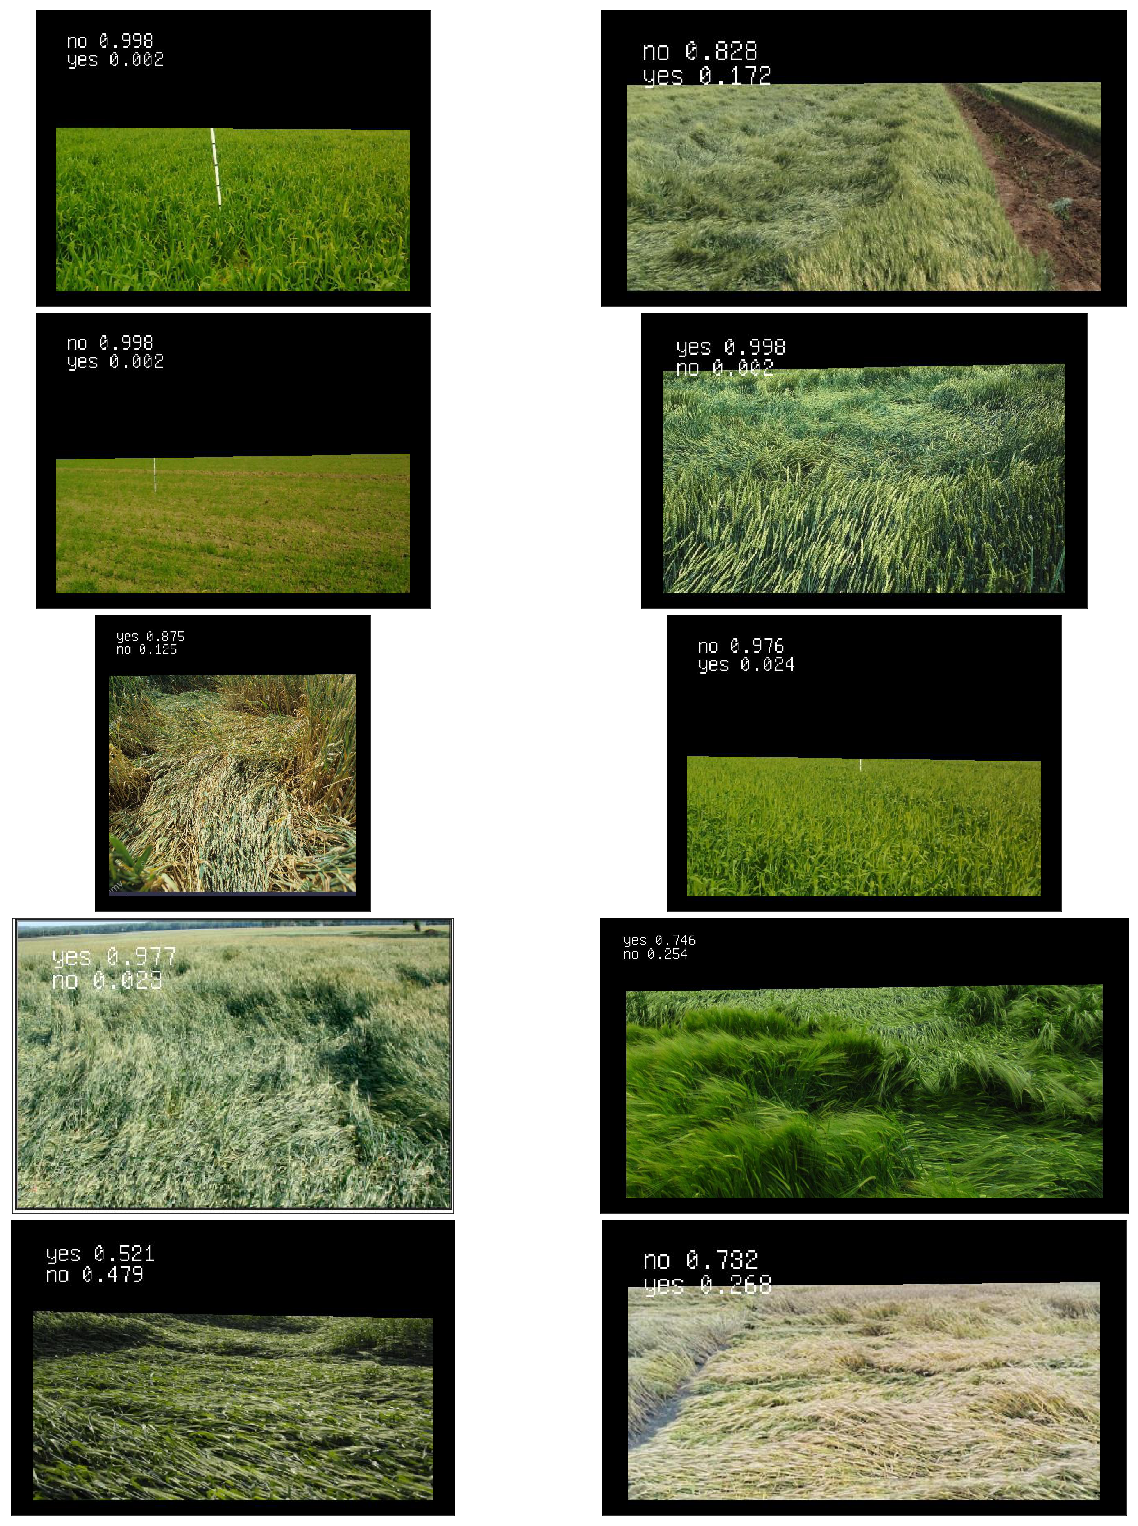

In [88]:
test_images = [plt.imread(path) for path in glob.glob('/media/ssd/crop_image_classifier/Data/TestingImages_Labels/*.jpg')]

show_images(test_images)

## Images labeled "Yes" for lodging

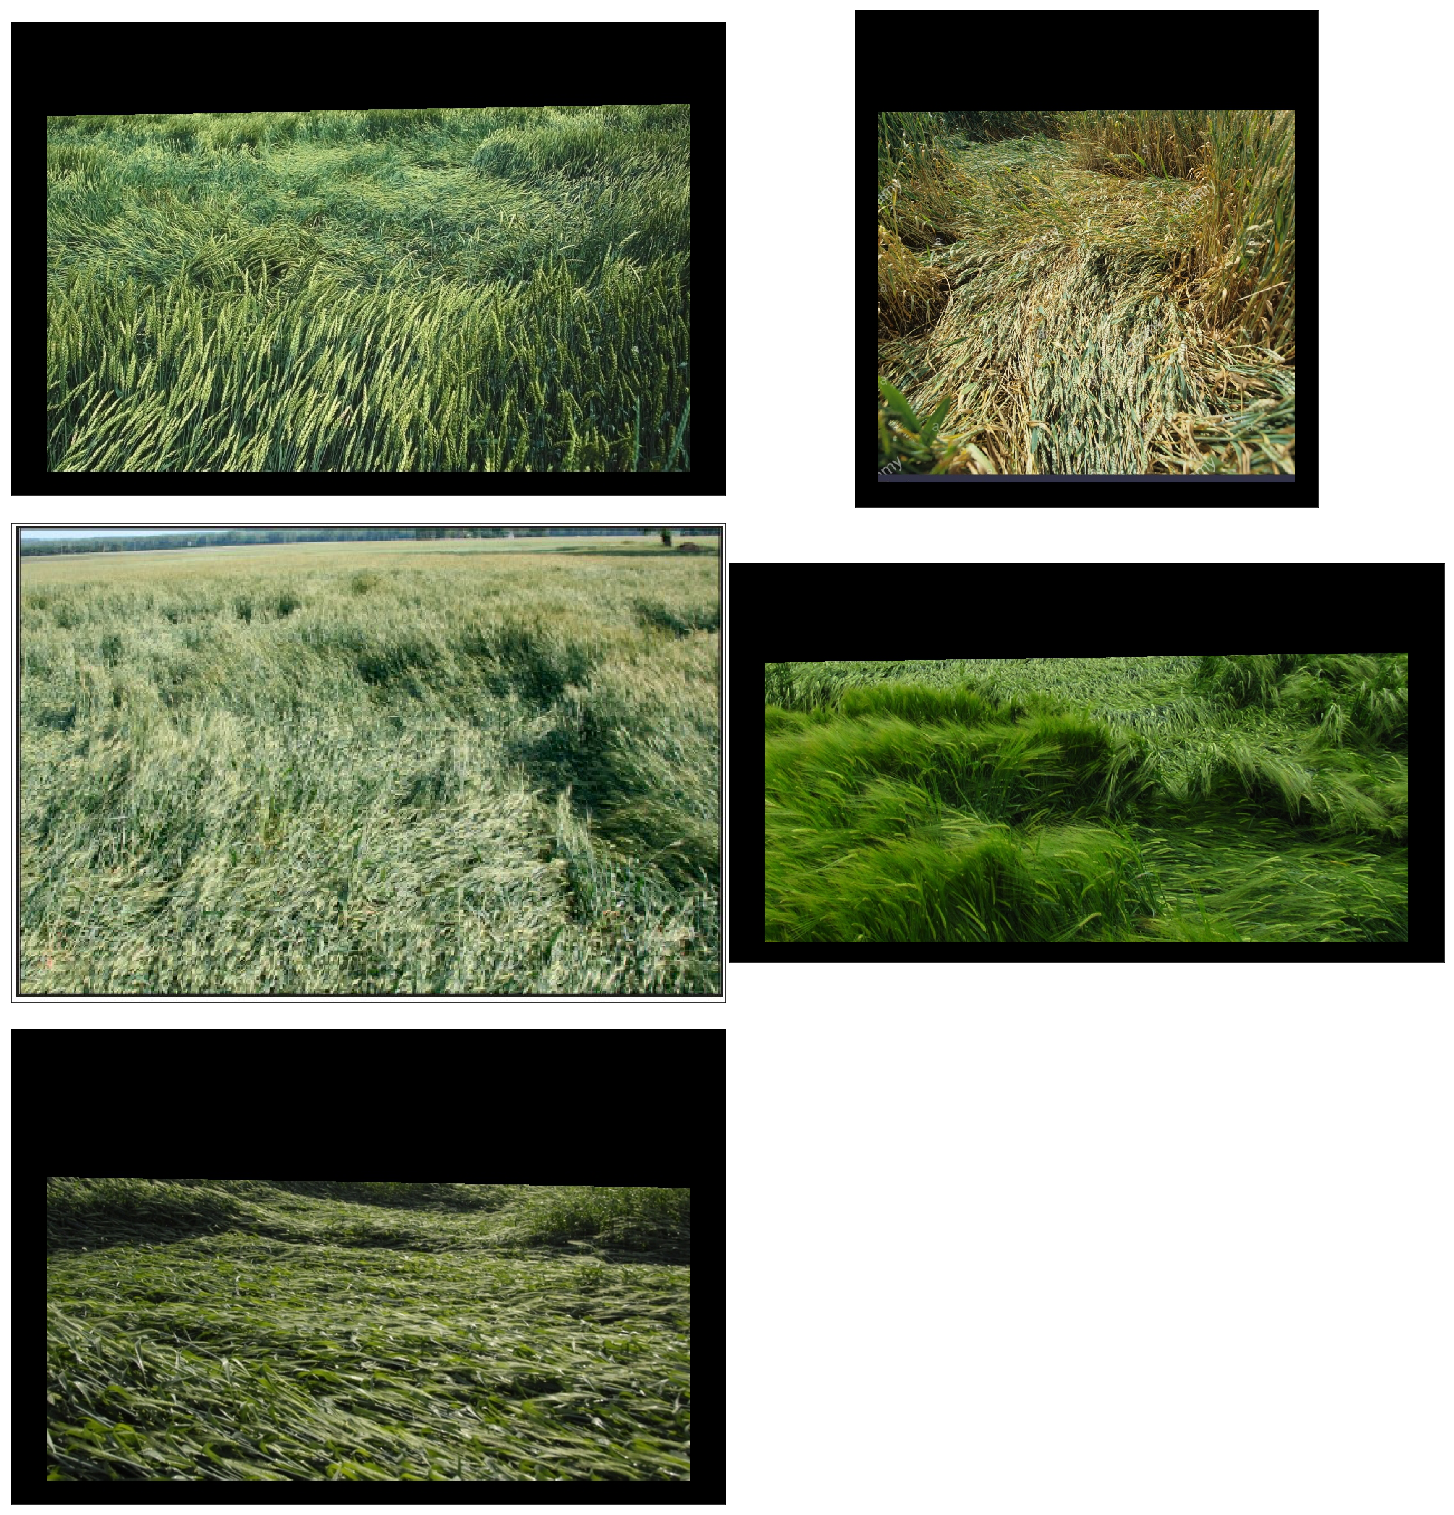

In [89]:
test_images = [plt.imread(path) for path in  df['Path'].loc[df['Class'] == 'yes'].tolist()]

show_images(test_images)

## Images labeled "No" for lodging

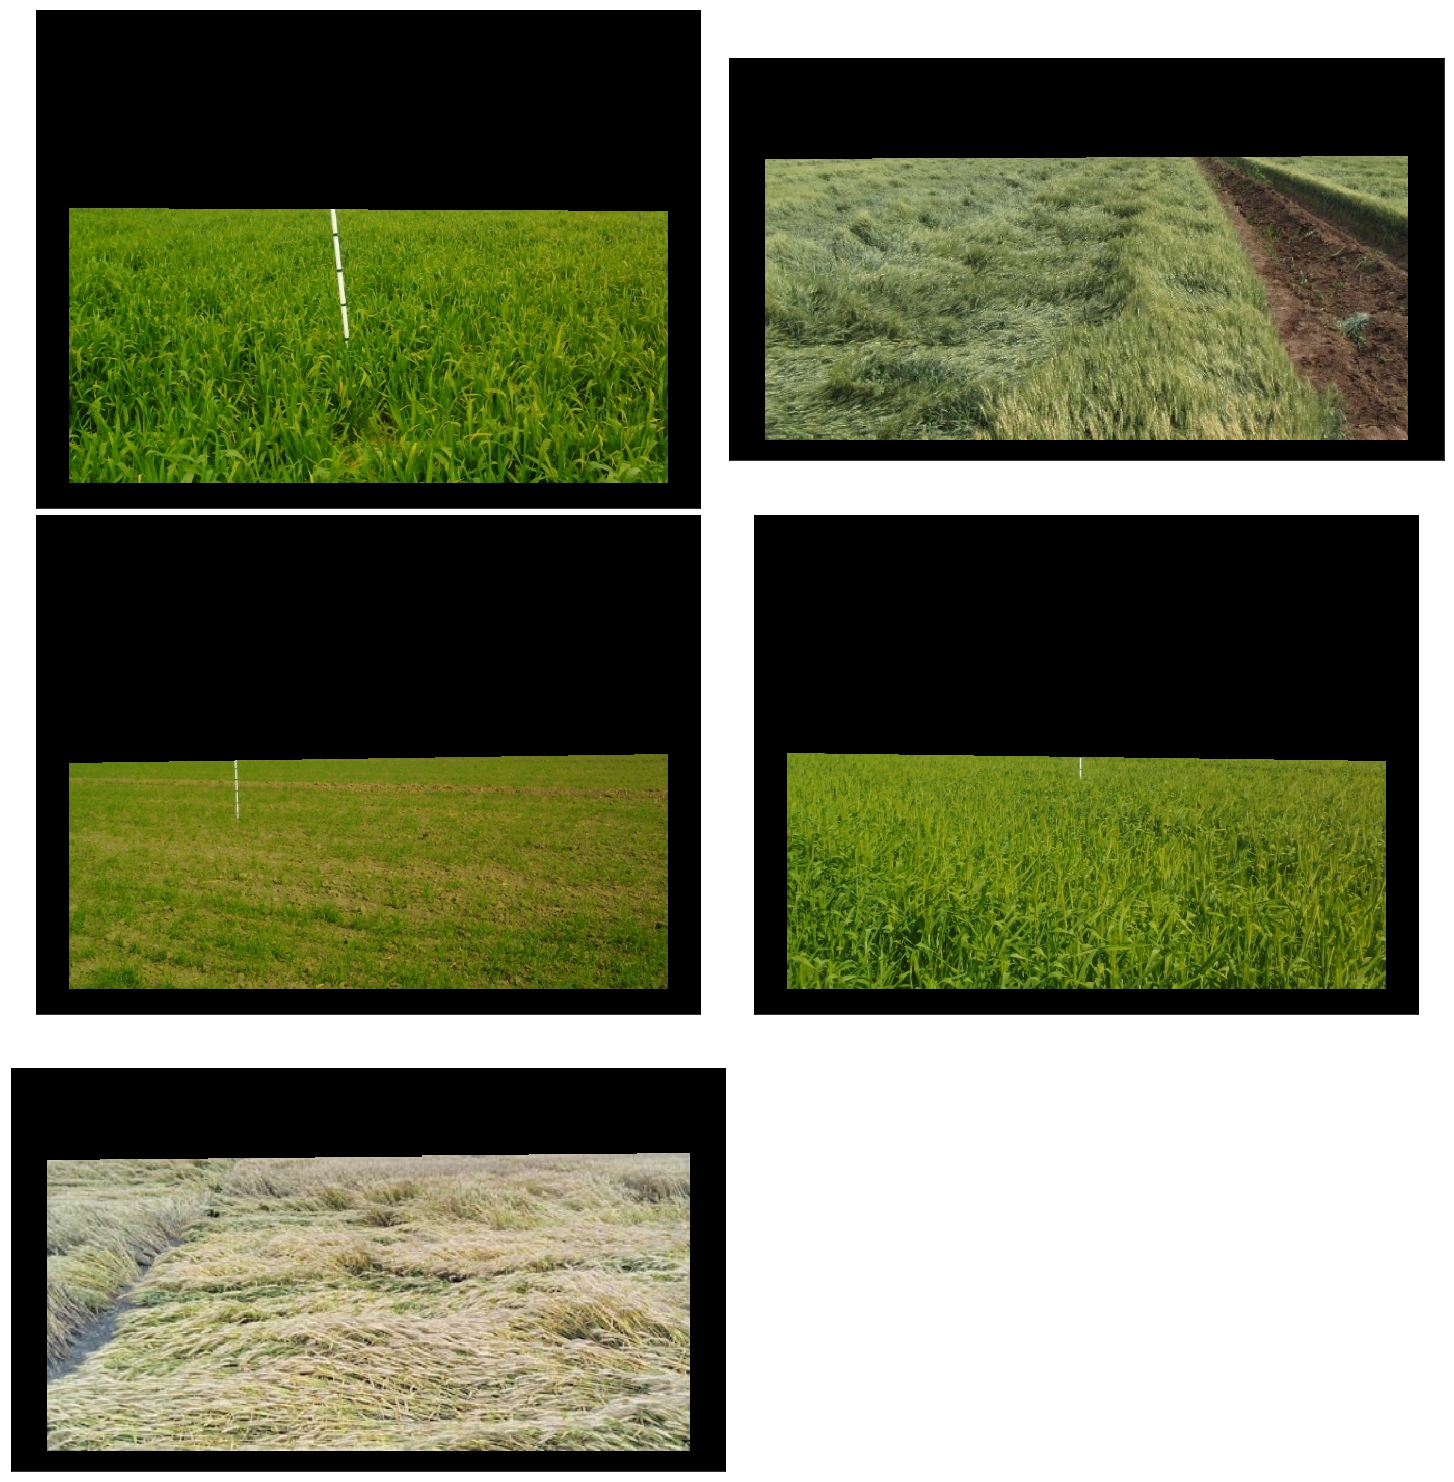

In [90]:
test_images = [plt.imread(path) for path in  df['Path'].loc[df['Class'] == 'no'].tolist()]

show_images(test_images)

Not perfect, but a good start. 